### Importing Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import tensorflow as tf
import json

In [ ]:
# create a data folder
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

# API Token
api_token = {"username":"zakawatabbas","key":"3232766635b8adeec2d0b263173cb03f"}

# File Opening
with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

# Permission for the json to act
!chmod 600 ~/.kaggle/kaggle.json

 # Dowload the dataset
! kaggle datasets download -d ananthu017/emotion-detection-fer

# # Extract from archive
!unzip "/content/emotion-detection-fer.zip" -d '/content/emotion-detection-fer/'

Streaming output truncated to the last 5000 lines.
  inflating: /content/emotion-detection-fer/train/sad/im37.png  
  inflating: /content/emotion-detection-fer/train/sad/im370.png  
  inflating: /content/emotion-detection-fer/train/sad/im3700.png  
  inflating: /content/emotion-detection-fer/train/sad/im3701.png  
  inflating: /content/emotion-detection-fer/train/sad/im3702.png  
  inflating: /content/emotion-detection-fer/train/sad/im3703.png  
  inflating: /content/emotion-detection-fer/train/sad/im3704.png  
  inflating: /content/emotion-detection-fer/train/sad/im3705.png  
  inflating: /content/emotion-detection-fer/train/sad/im3706.png  
  inflating: /content/emotion-detection-fer/train/sad/im3707.png  
  inflating: /content/emotion-detection-fer/train/sad/im3708.png  
  inflating: /content/emotion-detection-fer/train/sad/im3709.png  
  inflating: /content/emotion-detection-fer/train/sad/im371.png  
  inflating: /content/emotion-detection-fer/train/sad/im3710.png  
  inflating: /c

### Exploring the dataset

In [ ]:
print(os.listdir('/content/emotion-detection-fer/'))

['test', 'train']


In [ ]:
train_path = '/content/emotion-detection-fer/train'
val_path = '/content/emotion-detection-fer/test'

In [ ]:
# Importing TensorFlow libraries
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras import models, layers, regularizers
from tensorflow.keras import Sequential
from tensorflow import keras
from sklearn.model_selection import KFold

## Data Preprocessing

In [ ]:
emotion_labels = sorted(os.listdir(train_path))
print(emotion_labels)

['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']


In [ ]:
batch_size = 64
target_size = (48,48)

train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen   = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_path,
        target_size=target_size,
        batch_size=batch_size,
        color_mode="grayscale",
        class_mode='categorical',
        shuffle=True)

val_generator = val_datagen.flow_from_directory(
        val_path,
        target_size=target_size,
        batch_size=batch_size,
        color_mode="grayscale",
        class_mode='categorical')

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


# Data Summarization

### Dimensions of the Dataset

In [ ]:
input_shape = (48,48,1) # img_rows, img_colums, color_channels
num_classes = 7

### Breakdown of all data class variable

In [ ]:
def plot_images(img_dir, top=10):
    all_img_dirs = os.listdir(img_dir)
    img_files = [os.path.join(img_dir, file) for file in all_img_dirs][:5]

    plt.figure(figsize=(12, 12))

    for idx, img_path in enumerate(img_files):
        plt.subplot(5, 5, idx+1)
        img = plt.imread(img_path)
        plt.tight_layout()
        plt.imshow(img, cmap='gray')

Angry: 



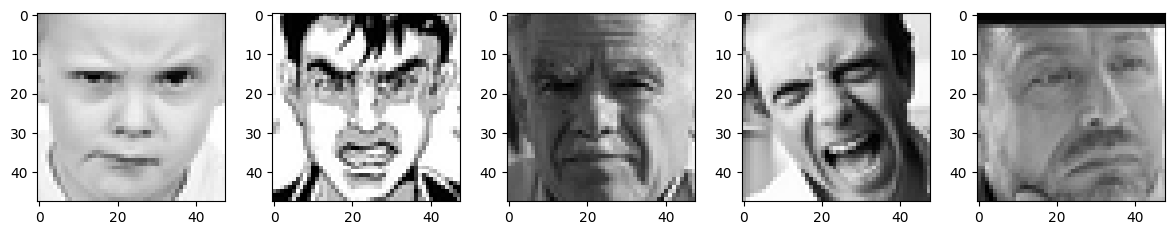

In [ ]:
print('Angry: ')
print()
plot_images(train_path+'/angry')

Disgust: 



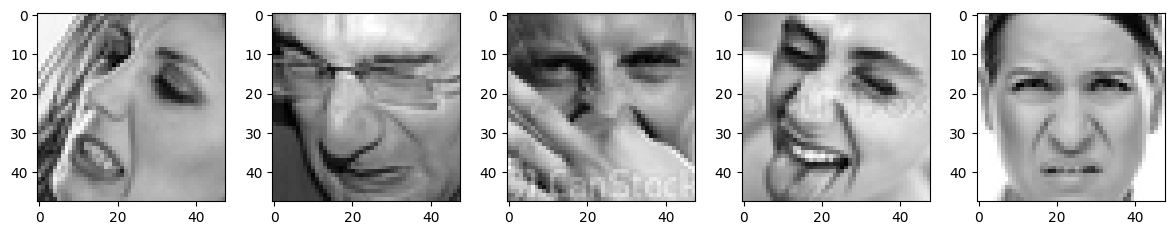

In [ ]:
print('Disgust: ')
print()
plot_images(train_path+'/disgusted')

Fear: 



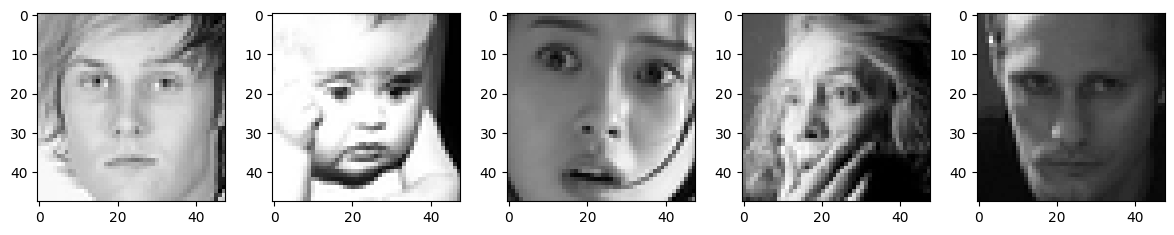

In [ ]:
print('Fear: ')
print()
plot_images(train_path+'/fearful')

Happy: 



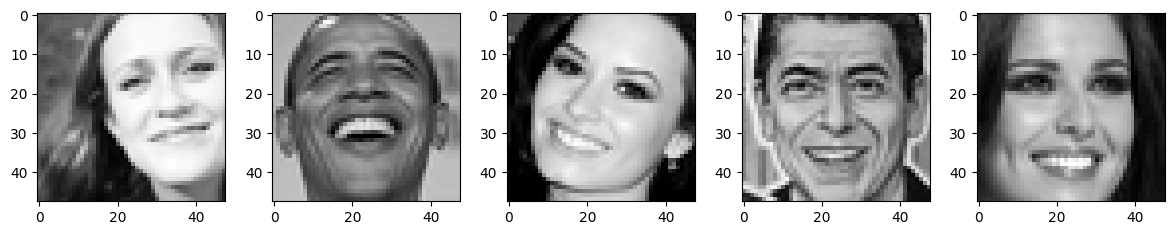

In [ ]:
print('Happy: ')
print()
plot_images(train_path+'/happy')

Neutral: 



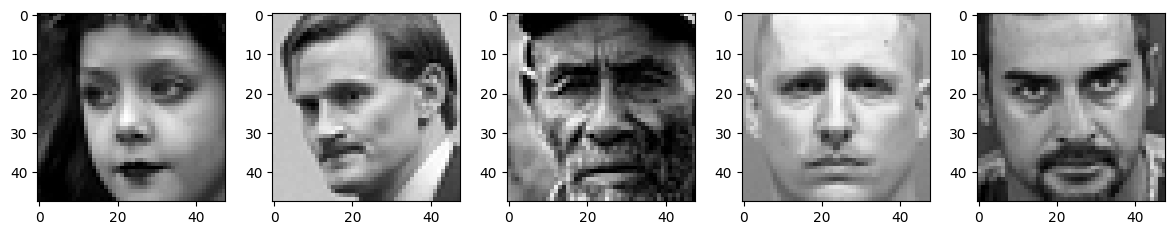

In [ ]:
print('Neutral: ')
print()
plot_images(train_path+'/neutral')

Sad: 



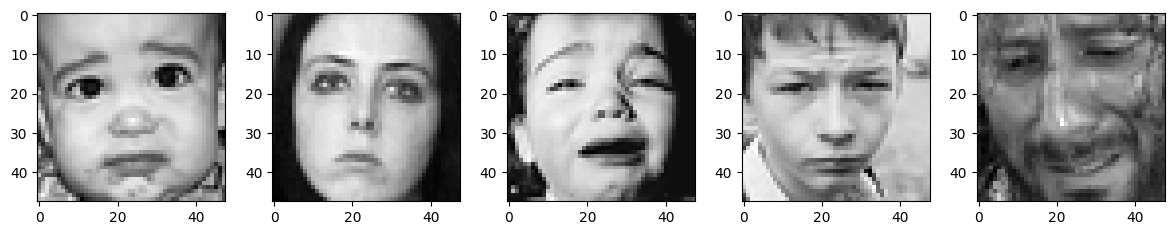

In [ ]:
print('Sad: ')
print()
plot_images(train_path+'/sad')

Surprise: 



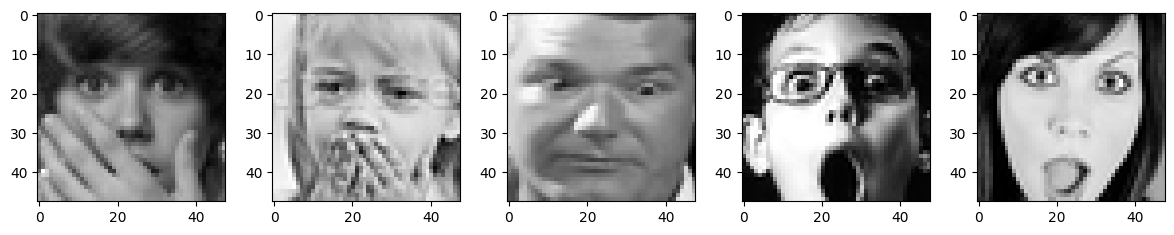

In [ ]:
print('Surprise: ')
print()
plot_images(train_path+'/surprised')

## Support Vector Machine (SVM)

### Building the Model

In [ ]:
num_epochs = 55
number_of_classes = 7

STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VAL   = val_generator.n//val_generator.batch_size

In [ ]:
model = Sequential()
model.add(layers.Conv2D(filters = 32, padding = "same",activation = "relu",kernel_size=3, strides = 2,input_shape=input_shape))
model.add(layers.MaxPool2D(pool_size=(2,2),strides = 2))

model.add(layers.Conv2D(filters = 32, padding = "same",activation = "relu",kernel_size=3))
model.add(layers.MaxPool2D(pool_size=(2,2),strides = 2))

model.add(layers.Flatten())
model.add(layers.Dense(128,activation="relu"))

#Output layer
model.add(layers.Dense(1,kernel_regularizer=regularizers.l2(0.01),activation = "linear"))

In [ ]:
model.add(layers.Dense(number_of_classes,kernel_regularizer = regularizers.l2(0.01),activation= "softmax"))
model.compile(optimizer="adam",loss="squared_hinge", metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 24, 24, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 12, 12, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 32)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 1152)              0         
                                                                 
 dense (Dense)               (None, 128)               1

### Training the Model

In [ ]:
history = model.fit(x=train_generator, steps_per_epoch=STEP_SIZE_TRAIN, epochs=num_epochs, batch_size=batch_size, validation_data=val_generator, validation_steps=STEP_SIZE_VAL)

Epoch 1/55
448/448 [==============================] - 25s 31ms/step - loss: 1.2187 - accuracy: 0.2787 - val_loss: 1.1944 - val_accuracy: 0.3145
Epoch 2/55
448/448 [==============================] - 14s 31ms/step - loss: 1.1863 - accuracy: 0.3247 - val_loss: 1.1823 - val_accuracy: 0.3426
Epoch 3/55
448/448 [==============================] - 14s 30ms/step - loss: 1.1761 - accuracy: 0.3419 - val_loss: 1.1705 - val_accuracy: 0.3520
Epoch 4/55
448/448 [==============================] - 13s 30ms/step - loss: 1.1697 - accuracy: 0.3540 - val_loss: 1.1657 - val_accuracy: 0.3597
Epoch 5/55
448/448 [==============================] - 13s 30ms/step - loss: 1.1656 - accuracy: 0.3603 - val_loss: 1.1633 - val_accuracy: 0.3742
Epoch 6/55
448/448 [==============================] - 13s 29ms/step - loss: 1.1619 - accuracy: 0.3715 - val_loss: 1.1595 - val_accuracy: 0.3804
Epoch 7/55
448/448 [==============================] - 14s 31ms/step - loss: 1.1594 - accuracy: 0.3741 - val_loss: 1.1620 - val_accuracy:

### Evaluate Model

In [ ]:
test_loss, test_accuracy = model.evaluate_generator(val_generator, steps=STEP_SIZE_VAL)

<ipython-input-25-b7cbb387dc62>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  test_loss, test_accuracy = model.evaluate_generator(val_generator, steps=STEP_SIZE_VAL)


### Show Training History

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


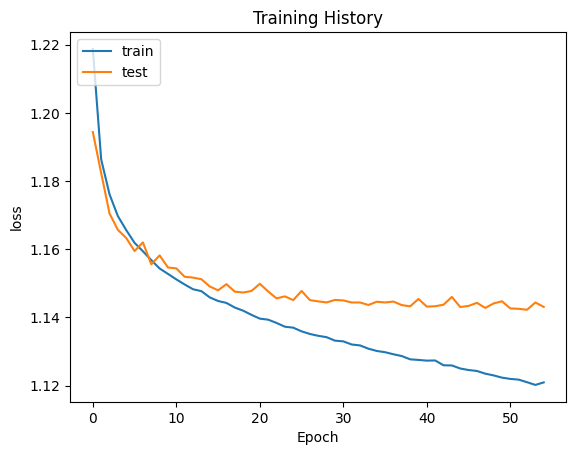

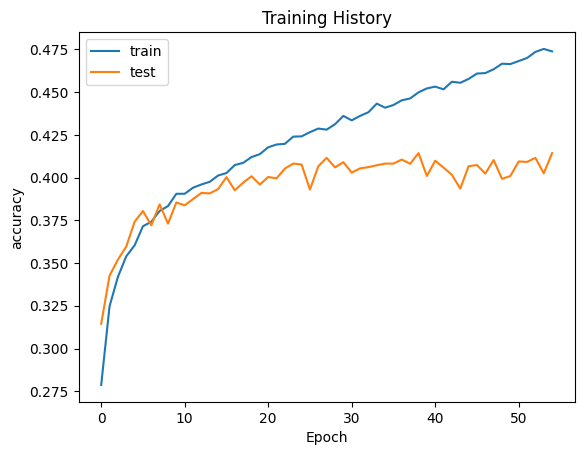

In [ ]:
keys=history.history.keys()
print(keys)

def show_train_history(hisData,train,test):
    plt.plot(hisData.history[train])
    plt.plot(hisData.history[test])
    plt.title('Training History')
    plt.ylabel(train)
    plt.xlabel('Epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

show_train_history(history, 'loss', 'val_loss')
show_train_history(history, 'accuracy', 'val_accuracy')

In [ ]:
# Print the training and testing scores
print("Training accuracy:", history.history['accuracy'][-1])
print("Testing accuracy:", test_accuracy)


Training accuracy: 0.47386977076530457
Testing accuracy: 0.4140625
